In [ ]:
# default_exp datasets.bases.ratings

# Ratings dataset
> Base class for ratings dataset module.

In [ ]:
#hide
from nbdev.showdoc import *
from fastcore.nb_imports import *
from fastcore.test import *

In [ ]:
#export
from typing import List, Optional, Callable, Union, Any, Tuple

import os
import numpy as np
import pandas as pd
import pickle

import torch

from recohut.utils.common_utils import download_url, extract_zip, extract_gz, makedirs
from recohut.utils.interaction_utils import user_activity_count, item_activity_count
from recohut.datasets.bases.common import Dataset

import matplotlib.pyplot as plt
import seaborn as sns
from recohut.visualization.basic_plots import BasicVisual

In [ ]:
df = pd.read_csv('https://github.com/RecoHut-Datasets/retail_general/raw/v3/rawdata.csv',
                 header = 0,
                 names = ['event','userid','itemid','timestamp'],
                 dtype={0:'category', 1:'category', 2:'category'},
                 parse_dates=['timestamp'])
df.head()

,event,userid,itemid,timestamp
0,view_item,2763227,11056,2020-01-13 16:05:31.244000+00:00
1,add_to_cart,2828666,14441,2020-01-13 22:36:38.680000+00:00
2,view_item,0620225789,14377,2020-01-14 10:54:41.886000+00:00
3,view_item,0620225789,14377,2020-01-14 10:54:47.692000+00:00
4,add_to_cart,0620225789,14377,2020-01-14 10:54:48.479000+00:00


In [ ]:
#exporti
class EventCountPlot(BasicVisual):
    def __init__(self, df, event, threshold, **kwargs):
        self.df = df
        self.event = event
        self.threshold = threshold
        super().__init__(**kwargs)

    def plot(self):
        sns.countplot(self.df.loc[self.df[self.event]>self.threshold, self.event])

In [ ]:
#exporti
class InteractionCountPlot(BasicVisual):
    def __init__(self, df, x, y, **kwargs):
        self.df = df
        self.x = x
        self.y = y
        super().__init__(**kwargs)

    def plot(self):
        sns.scatterplot(x=self.x, y=self.y, data=self.df, ax=self.ax)

In [ ]:
#exporti
class TimelinePlot(BasicVisual):
    def __init__(self, df, **kwargs):
        self.df = df
        super().__init__(**kwargs)

    def plot(self):
        self.ax = self.df['Count'].plot(marker='o', linestyle='-')

In [ ]:
#export
class InteractionData:
    def __init__(self, df, user_col='USERID', item_col='ITEMID', feedback_col=None, ts_col=None, *args, **kwargs):
        self.df = df
        self.user_col = user_col
        self.item_col = item_col
        self.feedback_col = feedback_col
        self.ts_col = ts_col

        self.df_user, self.user_activity = user_activity_count(df, user_col=user_col, event_col=feedback_col)
        self.df_item, self.item_activity = item_activity_count(df, item_col=item_col, event_col=feedback_col)
    
    def plot_user_interaction_counts(self):
        kwargs = {'x':'#Interactions', 'y':'#Users', 
                  'label_x':'#Interactions', 'label_y':'#Users', 
                  'figsize':(7,4), 'title':'User Interactions Plot'}
        _ = InteractionCountPlot(self.df_user, **kwargs)
    
    def plot_item_interaction_counts(self):
        kwargs = {'x':'#Interactions', 'y':'#Items', 
                  'label_x':'#Interactions', 'label_y':'#Items', 
                  'figsize':(7,4), 'title':'Item Interactions Plot'}
        _ = InteractionCountPlot(self.df_item, **kwargs)

    def plot_event_counts(self, event_name, threshold=0):
        kwargs = {'label_x':event_name, 'label_y':'Counts', 
                  'figsize':(7,4), 'title':'Event Counts Plot'}
        _ = EventCountPlot(self.user_activity, event=event_name, threshold=threshold, **kwargs)

    def plot_timeline(self, agg='day'):
        data = pd.DataFrame(pd.to_datetime(self.df[self.ts_col], infer_datetime_format=True))
        data['Count'] = 1
        data.set_index(self.ts_col, inplace=True)
        data = data.resample('D').apply({'Count':'count'})
        kwargs = {'label_x':'timestamp', 'label_y':'', 
                  'figsize':(15,4), 'title':'Timeline Plot'}
        _ = TimelinePlot(data, **kwargs)

In [ ]:
ds = InteractionData(df, user_col='userid', item_col='itemid', feedback_col='event', ts_col='timestamp')

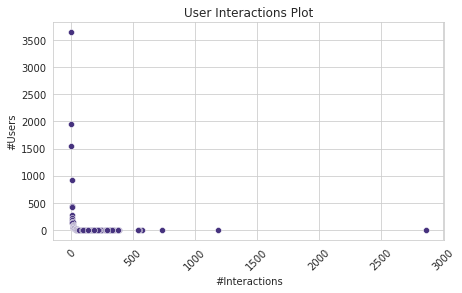

In [ ]:
ds.plot_user_interaction_counts()

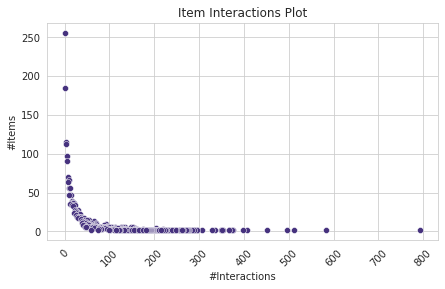

In [ ]:
ds.plot_item_interaction_counts()

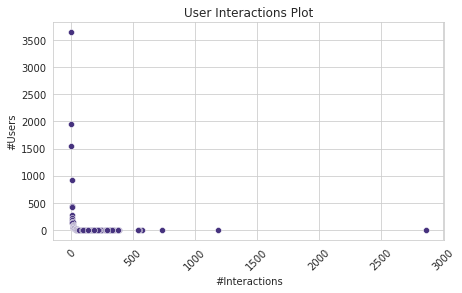

In [ ]:
ds.plot_user_interaction_counts()

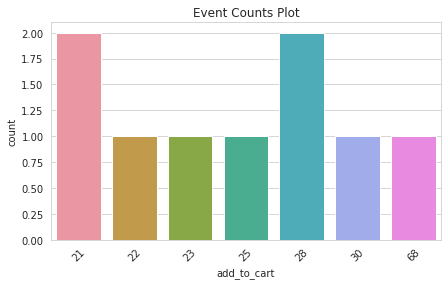

In [ ]:
ds.plot_event_counts(event_name='add_to_cart', threshold=20)

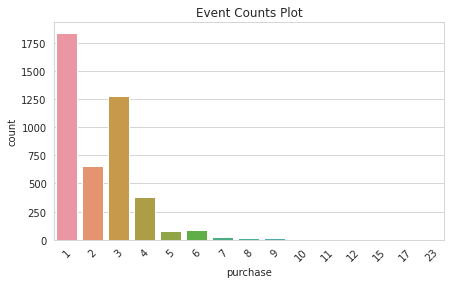

In [ ]:
ds.plot_event_counts(event_name='purchase', threshold=0)

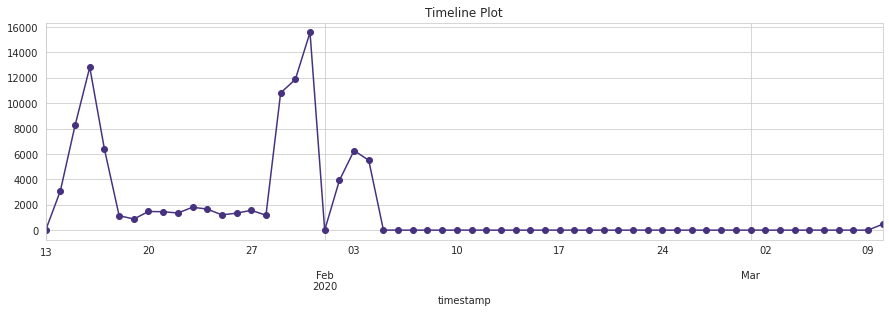

In [ ]:
ds.plot_timeline()

In [ ]:
#export
class RatingDataset(Dataset):
    r"""Interaction data with rating feedback
    
    Args:
        root: data folder path
        min_uc: minimum user count to keep in the data
        min_sc: minimum item count to keep in the data
        split: data split method - leave_one_out/holdout
        min_rating: minimum rating threshold to convert explicit feedback into implicit

    References:
        1. https://github.com/Yueeeeeeee/RecSys-Extraction-Attack/tree/main/datasets
    """
    def __init__(self, root, min_uc, min_sc, split='leave_one_out', dataset_split_seed=42,
                 eval_set_size=None, min_rating=None, iterative_triplet=False):
        super().__init__(root)
        self.min_rating = min_rating
        self.min_uc = min_uc
        self.min_sc = min_sc
        self.split = split
        self.dataset_split_seed = dataset_split_seed
        self.eval_set_size = eval_set_size
        self.iterative_triplet = iterative_triplet

        assert self.min_uc >= 2, 'Need at least 2 ratings per user for validation and test'

        self._process()

    def load_ratings_df(self):
        r"""load raw dataset into pandas dataframe"""
        raise NotImplementedError

    def load_processed(self):
        return pickle.load(open(self.processed_paths[0], 'rb'))

    @property
    def processed_file_names(self):
        return 'dataset.pkl'

    def make_implicit(self, df):
        print('Turning into implicit ratings')
        df = df[df['rating'] >= self.min_rating]
        # return df[['uid', 'sid', 'timestamp']]
        return df

    def filter_triplets(self, df):
        print('Filtering triplets')
        if self.min_sc > 0:
            item_sizes = df.groupby('sid').size()
            good_items = item_sizes.index[item_sizes >= self.min_sc]
            df = df[df['sid'].isin(good_items)]

        if self.min_uc > 0:
            user_sizes = df.groupby('uid').size()
            good_users = user_sizes.index[user_sizes >= self.min_uc]
            df = df[df['uid'].isin(good_users)]

        return df

    def filter_triplets_iteratively(self, df):
        print('Filtering triplets')
        if self.min_sc > 0 or self.min_uc > 0:
            item_sizes = df.groupby('sid').size()
            good_items = item_sizes.index[item_sizes >= self.min_sc]
            user_sizes = df.groupby('uid').size()
            good_users = user_sizes.index[user_sizes >= self.min_uc]
            while len(good_items) < len(item_sizes) or len(good_users) < len(user_sizes):
                if self.min_sc > 0:
                    item_sizes = df.groupby('sid').size()
                    good_items = item_sizes.index[item_sizes >= self.min_sc]
                    df = df[df['sid'].isin(good_items)]

                if self.min_uc > 0:
                    user_sizes = df.groupby('uid').size()
                    good_users = user_sizes.index[user_sizes >= self.min_uc]
                    df = df[df['uid'].isin(good_users)]

                item_sizes = df.groupby('sid').size()
                good_items = item_sizes.index[item_sizes >= self.min_sc]
                user_sizes = df.groupby('uid').size()
                good_users = user_sizes.index[user_sizes >= self.min_uc]
            
        return df

    def densify_index(self, df):
        print('Densifying index')
        umap = {u: i for i, u in enumerate(set(df['uid']))}
        smap = {s: i for i, s in enumerate(set(df['sid']))}
        df['uid'] = df['uid'].map(umap)
        df['sid'] = df['sid'].map(smap)
        return df, umap, smap

    def split_df(self, df, user_count):
        if self.split == 'leave_one_out':
            print('Splitting')
            user_group = df.groupby('uid')
            user2items = user_group.progress_apply(lambda d: list(d.sort_values(by='timestamp')['sid']))
            train, val, test = {}, {}, {}
            for user in range(user_count):
                items = user2items[user]
                train[user], val[user], test[user] = items[:-2], items[-2:-1], items[-1:]
            return train, val, test
        elif self.split == 'holdout':
            print('Splitting')
            np.random.seed(self.dataset_split_seed)
            eval_set_size = self.eval_set_size

            # Generate user indices
            permuted_index = np.random.permutation(user_count)
            train_user_index = permuted_index[                :-2*eval_set_size]
            val_user_index   = permuted_index[-2*eval_set_size:  -eval_set_size]
            test_user_index  = permuted_index[  -eval_set_size:                ]

            # Split DataFrames
            train_df = df.loc[df['uid'].isin(train_user_index)]
            val_df   = df.loc[df['uid'].isin(val_user_index)]
            test_df  = df.loc[df['uid'].isin(test_user_index)]

            # DataFrame to dict => {uid : list of sid's}
            train = dict(train_df.groupby('uid').progress_apply(lambda d: list(d['sid'])))
            val   = dict(val_df.groupby('uid').progress_apply(lambda d: list(d['sid'])))
            test  = dict(test_df.groupby('uid').progress_apply(lambda d: list(d['sid'])))
            return train, val, test
        else:
            raise NotImplementedError

    def process(self):
        df = self.load_ratings_df()
        if self.iterative_triplet:
            df = self.filter_triplets_iteratively(df)
        else:
            df = self.filter_triplets(df)
        df, umap, smap = self.densify_index(df)
        train, val, test = self.split_df(df, len(umap))
        dataset = {'train': train,
                   'val': val,
                   'test': test,
                   'umap': umap,
                   'smap': smap}
        with open(self.processed_paths[0], 'wb') as f:
            pickle.dump(dataset, f)

Example

In [ ]:
class AmazonGamesDataset(RatingDataset):
    url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Video_Games.csv"

    @property
    def raw_file_names(self):
        return 'ratings_Video_Games.csv'

    def download(self):
        download_url(self.url, self.raw_dir)

    def load_ratings_df(self):
        df = pd.read_csv(self.raw_paths[0], header=None)
        df.columns = ['uid', 'sid', 'rating', 'timestamp']
        return df

In [ ]:
ds = AmazonGamesDataset(root='/content/amazon_games', min_uc=10, min_sc=5)

Processing...


Filtering triplets
Densifying index
Splitting


100%|██████████| 7519/7519 [00:05<00:00, 1295.99it/s]
Done!


In [ ]:
class AmazonBeautyDataset(RatingDataset):
    url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Beauty.csv"

    @property
    def raw_file_names(self):
        return 'ratings_Beauty.csv'

    def download(self):
        download_url(self.url, self.raw_dir)

    def load_ratings_df(self):
        df = pd.read_csv(self.raw_paths[0], header=None)
        df.columns = ['uid', 'sid', 'rating', 'timestamp']
        return df

In [ ]:
ds = AmazonGamesDataset(root='/content/amazon_beauty', min_uc=10, min_sc=5)

Processing...


Filtering triplets
Densifying index
Splitting


100%|██████████| 7519/7519 [00:02<00:00, 2527.69it/s]
Done!


In [ ]:
class ML1mDataset(RatingDataset):
    url = "http://files.grouplens.org/datasets/movielens/ml-1m.zip"

    @property
    def raw_file_names(self):
        return 'ratings.dat'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        from shutil import move, rmtree
        move(os.path.join(self.raw_dir, 'ml-1m', self.raw_file_names), self.raw_dir)
        rmtree(os.path.join(self.raw_dir, 'ml-1m'))
        os.unlink(path)

    def load_ratings_df(self):
        df = pd.read_csv(self.raw_paths[0], sep='::', header=None, engine='python')
        df.columns = ['uid', 'sid', 'rating', 'timestamp']
        return df

In [ ]:
ds = ML1mDataset(root='/content/ML1m', min_uc=10, min_sc=5)

Processing...


Filtering triplets
Densifying index
Splitting


100%|██████████| 6040/6040 [00:02<00:00, 2590.97it/s]
Done!


In [ ]:
class SteamGamesDataset(RatingDataset):
    url = "http://cseweb.ucsd.edu/~wckang/steam_reviews.json.gz"

    @property
    def raw_file_names(self):
        return 'steam_reviews.json'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_gz(path, self.raw_dir)
        os.unlink(path)

    def load_ratings_df(self):
        data = []
        f = open(self.raw_paths[0], 'r', encoding='utf-8')
        import ast
        for line in f.readlines():
            temp = ast.literal_eval(line)
            data.append([temp['username'], temp['product_id'], temp['date']])

        return pd.DataFrame(data, columns=['uid', 'sid', 'timestamp'])

In [ ]:
ds = SteamGamesDataset(root='/content/steam', min_uc=10, min_sc=5)

Processing...


Filtering triplets
Densifying index
Splitting


100%|██████████| 120145/120145 [01:10<00:00, 1709.62it/s]
Done!


In [ ]:
class YoochooseDataset(RatingDataset):
    url = "https://s3-eu-west-1.amazonaws.com/yc-rdata/yoochoose-data.7z"

    @property
    def raw_file_names(self):
        return 'yoochoose-clicks.dat'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        # pip install pyunpack patool
        import pyunpack
        pyunpack.Archive(path).extractall(self.raw_dir)
        os.unlink(path)

    def load_ratings_df(self):
        df = pd.read_csv(self.raw_paths[0], header=None)
        df.columns = ['uid', 'timestamp', 'sid', 'category']
        return df

In [ ]:
ds = YoochooseDataset(root='/content/yoochoose', min_uc=10, min_sc=5)

Processing...
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.


Filtering triplets
Densifying index
Splitting


100%|██████████| 449961/449961 [03:55<00:00, 1913.52it/s]
Done!


## Torch Rating Dataset

In [ ]:
#export
class TorchRatingDataset(torch.utils.data.Dataset):
    """Wrapper, convert <user, item, rating> Tensor into Pytorch Dataset."""

    def __init__(self, user_tensor, item_tensor, target_tensor):
        """Init UserItemRatingDataset Class.
        Args:
            target_tensor: torch.Tensor, the corresponding rating for <user, item> pair.
        """
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        """Get an item from dataset."""
        return (
            self.user_tensor[index],
            self.item_tensor[index],
            self.target_tensor[index],
        )

    def __len__(self):
        """Get the size of the dataset."""
        return self.user_tensor.size(0)

In [ ]:
#export
class TorchPairwiseNegativeDataset(torch.utils.data.Dataset):
    """Wrapper, convert <user, pos_item, neg_item> Tensor into Pytorch Dataset."""

    def __init__(self, user_tensor, pos_item_tensor, neg_item_tensor):
        """Init PairwiseNegativeDataset Class.
        Args:
            target_tensor: torch.Tensor, the corresponding rating for <user, item> pair.
        """
        self.user_tensor = user_tensor
        self.pos_item_tensor = pos_item_tensor
        self.neg_item_tensor = neg_item_tensor

    def __getitem__(self, index):
        """Get an item from the dataset."""
        return (
            self.user_tensor[index],
            self.pos_item_tensor[index],
            self.neg_item_tensor[index],
        )

    def __len__(self):
        """Get the size of the dataset."""
        return self.user_tensor.size(0)

> **References:-**
- https://github.com/beta-team/beta-recsys/blob/master/beta_rec/data/data_loaders.py

In [ ]:
#hide
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d -p recohut

Author: Sparsh A.

Last updated: 2021-12-31 06:27:08

recohut: 0.0.8

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.144+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

sys    : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
numpy  : 1.19.5
pandas : 1.1.5
csv    : 1.0
IPython: 5.5.0

